In [14]:
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
import copy
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import linalg as LA
cwd = os.getcwd()  # Get the current working directory (cwd)
x_train_p = os.path.join(cwd, 'train-images.idx3-ubyte')
y_train_p = os.path.join(cwd, 'train-labels.idx1-ubyte')
x_test_p = os.path.join(cwd, 't10k-images.idx3-ubyte')
y_test_p = os.path.join(cwd, 't10k-labels.idx1-ubyte')

# Load everything in numpy arrays
with open(y_train_p, 'rb') as y_train_f:
    magic, num = struct.unpack(">II", y_train_f.read(8))
    y_train = np.fromfile(y_train_f, dtype=np.int8)
with open(y_test_p, 'rb') as y_test_f:
    magic, num = struct.unpack(">II", y_test_f.read(8))
    y_test = np.fromfile(y_test_f, dtype=np.int8)
with open(x_train_p, 'rb') as x_train_f:
    magic, num, rows, cols = struct.unpack(">IIII", x_train_f.read(16))
    x_train = np.fromfile(x_train_f, dtype=np.uint8).reshape(len(y_train), rows*cols)
with open(x_test_p, 'rb') as x_test_f:
    magic, num, rows, cols = struct.unpack(">IIII", x_test_f.read(16))
    x_test = np.fromfile(x_test_f, dtype=np.uint8).reshape(len(y_test), rows*cols)
im_size = x_train.shape[1]
train_size = x_train.shape[0]
test_size = x_test.shape[0]





train_mean=np.mean(x_train,axis=0)
train_mean[0]=0
train_std=np.std(x_train,axis=0)
for i in range(im_size):
    if train_std[i]==0.:
        train_std[i]=1
x_train=(x_train-train_mean)/train_std
x_test=(x_test-train_mean)/train_std


t_train=np.zeros((train_size,10))
t_test=np.zeros((test_size,10))
for i in range(train_size):
    t_train[i][y_train[i]]=1
for i in range(test_size):
    t_test[i][y_test[i]]=1
    
iteration=5000
input_layer=28*28
hidden_layer=20
output_layer=10

eta=1e-2
_lambda=0
batch_size=60000
num_batch=1
wt_lim=0.01


In [15]:
W1 = wt_lim * np.random.randn(input_layer+1, hidden_layer)
W2 = wt_lim * np.random.randn(hidden_layer+1, output_layer)
G1=np.zeros((input_layer+1,hidden_layer))
G2=np.zeros((hidden_layer+1,output_layer))

In [16]:
from numba import jit
@jit
def shuffle(x,y,t):
    np.random.seed(1234)
    p=np.random.permutation(len(x))
    return x[p],y[p],t[p]
x_train,y_train,t_train=shuffle(x_train,y_train,t_train)
@jit
def sigmoid(x):
    return 1./(1+np.exp(-x))
@jit 
def softmax(x):
    mx=np.amax(x,axis=0)
    sm=np.sum(np.exp(x-mx),axis=0)
    return np.exp(x-mx)/sm
@jit 
def sigmoid_prime(x):
    return x*(1-x)

@jit
def error(output_layer_state, Y):
    mx = np.argmax(output_layer_state, axis=0).reshape(-1, 1)
    return (100 * ((mx!=Y.reshape(-1, 1))*1.0).sum()/len(Y))

@jit
def forward_prop(X):
    a, b = X.shape
    X = np.vstack((np.ones((1,b)), X)) # Add 1 for bias term
    hidden_layer_state = sigmoid(W1.T.dot(X))
    hidden_layer_state = np.vstack((np.ones((1,b)), hidden_layer_state)) # Add 1 for bias term
    output_layer_state = softmax(W2.T.dot(hidden_layer_state))
    return hidden_layer_state, output_layer_state
@jit
def RELU(x):
    return np.maximum(x,0)
@jit
def RELU_prime(x):
    return (x>0)*1.


In [17]:
error_train_list=list()
error_test_list=list()
for epoch in range(10):
    (hidden_layer_state, output_layer_state) = forward_prop(x_train.T)
    train_err = error(output_layer_state, y_train)
    error_train_list.append(train_err)
    (hidden_layer_state, output_layer_state) = forward_prop(x_test.T)
    test_err = error(output_layer_state, y_test)
    error_test_list.append(test_err)
    print('After ', (epoch+1), 'th epoch, training error', train_err)
    print('After ', (epoch+1), 'th epoch, test error', test_err)
    for n in range(0,60000,1): 
        (hidden_layer_state, output_layer_state) = forward_prop(x_train[n:n+1,:].T)
       # Back propagation
        d2 = t_train[n:n+1,:].T - output_layer_state
        G2 = -hidden_layer_state.dot(d2.T)
        d1 =  W2.dot(d2)[1:] * sigmoid_prime(hidden_layer_state[1:])
        G1 = -np.vstack((np.ones((1,1)), x_train[n:n+1,:].T)).dot(d1.T)

        G1 = G1 + _lambda * np.vstack((np.zeros((1,hidden_layer)), ((W1[1:,:]))))
 
        G2 = G2 + _lambda * np.vstack((np.zeros((1,output_layer)), W2[1:,:]))

        W1=W1-eta*G1
        W2=W2-eta*G2
   




<ipython-input-16-38e1b854450d>:25: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "forward_prop" failed type inference due to: Invalid use of type(CPUDispatcher(<function softmax at 0x00000249819991E0>)) with parameters (array(float64, 2d, C))
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function softmax at 0x00000249819991E0>))
[2] During: typing of call at <ipython-input-16-38e1b854450d> (31)


File "<ipython-input-16-38e1b854450d>", line 31:
def forward_prop(X):
    <source elided>
    hidden_layer_state = np.vstack((np.ones((1,b)), hidden_layer_state)) # Add 1 for bias term
    output_layer_state = softmax(W2.T.dot(hidden_layer_state))
    ^

  @jit
C:\Users\rimsh\Anaconda3\lib\site-packages\numba\compiler.py:725: NumbaWarning: Function "forward_prop" was compiled in object mode without forceobj=True.

File "<ipython-input-16-38e1b854450d>", line 26:
@jit
def forward_prop(X):
^

  self.func_ir.loc))
C:

After  1 th epoch, training error 90.25666666666666
After  1 th epoch, test error 90.48


C:\Users\rimsh\Anaconda3\lib\site-packages\numba\compiler.py:725: NumbaWarning: Function "forward_prop" was compiled in object mode without forceobj=True.

File "<ipython-input-16-38e1b854450d>", line 26:
@jit
def forward_prop(X):
^

  self.func_ir.loc))
C:\Users\rimsh\Anaconda3\lib\site-packages\numba\compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-16-38e1b854450d>", line 26:
@jit
def forward_prop(X):
^

  warnings.warn(errors.NumbaDeprecationWarning(msg, self.func_ir.loc))


After  2 th epoch, training error 6.488333333333333
After  2 th epoch, test error 6.97
After  3 th epoch, training error 5.583333333333333
After  3 th epoch, test error 6.48
After  4 th epoch, training error 5.096666666666667
After  4 th epoch, test error 6.42
After  5 th epoch, training error 4.756666666666667
After  5 th epoch, test error 6.38
After  6 th epoch, training error 4.54
After  6 th epoch, test error 6.26
After  7 th epoch, training error 4.34
After  7 th epoch, test error 6.32
After  8 th epoch, training error 4.07
After  8 th epoch, test error 6.27
After  9 th epoch, training error 3.973333333333333
After  9 th epoch, test error 6.22
After  10 th epoch, training error 3.815
After  10 th epoch, test error 6.3


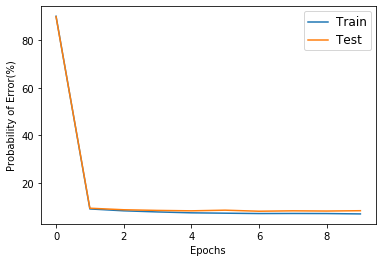

In [13]:
plt.plot(range(0,len(error_train_list)),error_train_list,label='Train')
plt.plot(range(0,len(error_test_list)),error_test_list,label='Test')
plt.xlabel('Epochs')
plt.ylabel('Probability of Error(%)')
legend=plt.legend()
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth('1.5')

In [9]:
import numpy as np
import random
print(random.choices([12],1))

TypeError: 'int' object is not iterable

In [15]:
for i in range(0,10,2):
    print(i)

0
2
4
6
8
